# Text classification with Pytorch

The goal of this TP is double: an introduction to using Pytorch for treating textual data, and implementing neural classification models that we can apply to the same dataset as before - **here, 20 newsgroup** - and then compare to models implemented in the previous TP. 

In [ ]:
import torch
import torch.nn as nn

### A (very small) introduction to pytorch

Pytorch Tensors are very similar to Numpy arrays, with the added benefit of being usable on GPU. For a short tutorial on various methods to create tensors of particular types, see [this link](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).
The important things to note are that Tensors can be created empty, from lists, and it is very easy to convert a numpy array into a pytorch tensor, and inversely.

In [ ]:
a = torch.LongTensor(5)
b = torch.LongTensor([5])

print(a)
print(b)

tensor([139954452065392,       136003344,       137989968,             129,
        139954452065360])
tensor([5])


In [ ]:
a = torch.FloatTensor([2])
b = torch.FloatTensor([3])

print(a + b)

tensor([5.])


The main interest in us using Pytorch is the ```autograd``` package. ```torch.Tensor```objects have an attribute ```.requires_grad```; if set as True, it starts to track all operations on it. When you finish your computation, can call ```.backward()``` and all the gradients are computed automatically (and stored in the ```.grad``` attribute).

One way to easily cut a tensor from the computational once it is not needed anymore is to use ```.detach()```.
More info on automatic differentiation in pytorch on [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py).


In [ ]:
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph.
y = w * x + b    # y = 2 * x + 3

# Compute gradients.
y.backward()

# Print out the gradients.
print(x.grad)    # x.grad = 2 
print(w.grad)    # w.grad = 1 
print(b.grad)    # b.grad = 1 

tensor(2.)
tensor(1.)
tensor(1.)


In [ ]:
x = torch.randn(10, 3)
y = torch.randn(10, 2)

# Build a fully connected layer.
linear = nn.Linear(3, 2)
for name, p in linear.named_parameters():
    print(name)
    print(p)

# Build loss function - Mean Square Error
criterion = nn.MSELoss()

# Forward pass.
pred = linear(x)

# Compute loss.
loss = criterion(pred, y)
print('Initial loss: ', loss.item())

# Backward pass.
loss.backward()

# Print out the gradients.
print ('dL/dw: ', linear.weight.grad) 
print ('dL/db: ', linear.bias.grad)

weight
Parameter containing:
tensor([[-0.5182,  0.0535,  0.1116],
        [-0.2481,  0.2607, -0.2130]], requires_grad=True)
bias
Parameter containing:
tensor([-0.3184,  0.1410], requires_grad=True)
Initial loss:  0.6964296102523804
dL/dw:  tensor([[-0.3357,  0.0257,  0.0415],
        [-0.2455, -0.2640, -0.2093]])
dL/db:  tensor([-0.0352,  0.2400])


In [ ]:
# You can perform gradient descent manually, with an in-place update ...
linear.weight.data.sub_(0.01 * linear.weight.grad.data)
linear.bias.data.sub_(0.01 * linear.bias.grad.data)

# Print out the loss after 1-step gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after one update: ', loss.item())

Loss after one update:  0.6929665803909302


In [ ]:
# Use the optim package to define an Optimizer that will update the weights of the model.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

# By default, gradients are accumulated in buffers( i.e, not overwritten) whenever .backward()
# is called. Before the backward pass, we need to use the optimizer object to zero all of the
# gradients.
optimizer.zero_grad()
loss.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

# Print out the loss after the second step of gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after two updates: ', loss.item())

Loss after two updates:  0.6895546913146973


### Tools for data processing 

```torch.utils.data.Dataset``` is an abstract class representing a dataset. Your custom dataset should inherit ```Dataset``` and override the following methods:
- ```__len__``` so that ```len(dataset)``` returns the size of the dataset.
- ```__getitem__``` to support the indexing such that ```dataset[i]``` can be used to get the i-th sample

Here is a toy example: 

In [ ]:
toy_corpus = ['I walked down down the boulevard',
              'I walked down the avenue',
              'I ran down the boulevard',
              'I walk down the city',
              'I walk down the the avenue']

toy_categories = [0, 0, 1, 0, 0]

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    # A pytorch dataset class for holding data for a text classification task.
    def __init__(self, data, categories):
        # Upon creating the Dataset object, store the data in an attribute
        # Split the text data and labels from each other
        self.X, self.Y = [], []
        for x, y in zip(data, categories):
            # We will propably need to preprocess the data - have it done in a separate method
            # We do it here because we might need corpus-wide info to do the preprocessing 
            # For example, cutting all examples to the same length
            self.X.append(self.preprocess(x))
            self.Y.append(y)
                
    # Method allowing you to preprocess data                      
    def preprocess(self, text):
        text_pp = text.lower().strip()
        return text_pp
    
    # Overriding the method __len__ so that len(CustomDatasetName) returns the number of data samples                     
    def __len__(self):
        return len(self.Y)
   
    # Overriding the method __getitem__ so that CustomDatasetName[i] returns the i-th sample of the dataset                      
    def __getitem__(self, idx):
           return self.X[idx], self.Y[idx]

In [ ]:
toy_dataset = CustomDataset(toy_corpus, toy_categories)

In [ ]:
print(len(toy_dataset))
for i in range(len(toy_dataset)):
    print(toy_dataset[i])

5
('i walked down down the boulevard', 0)
('i walked down the avenue', 0)
('i ran down the boulevard', 1)
('i walk down the city', 0)
('i walk down the the avenue', 0)


```torch.utils.data.DataLoader``` is what we call an iterator, which provides very useful features:
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.
and can be created very simply from a ```Dataset```. Continuing on our simple example: 

In [ ]:
toy_dataloader = DataLoader(toy_dataset, batch_size = 2, shuffle = True)

In [ ]:
for e in range(3):
    print("Epoch:" + str(e))
    for x, y in toy_dataloader:
        print("Batch: " + str(x) + "; labels: " + str(y))  

Epoch:0
Batch: ('i walked down down the boulevard', 'i walked down the avenue'); labels: tensor([0, 0])
Batch: ('i walk down the city', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walk down the the avenue',); labels: tensor([0])
Epoch:1
Batch: ('i walked down the avenue', 'i walk down the city'); labels: tensor([0, 0])
Batch: ('i walk down the the avenue', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walked down down the boulevard',); labels: tensor([0])
Epoch:2
Batch: ('i walk down the city', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walked down the avenue', 'i walked down down the boulevard'); labels: tensor([0, 0])
Batch: ('i walk down the the avenue',); labels: tensor([0])


### Data processing of a text dataset

Now, we would like to apply what we saw to our case, and **create a specific class** ```TextClassificationDataset``` **inheriting** ```Dataset``` that will:
- Create a vocabulary from the data (use what we saw in the previous TP)
- Preprocess the data using this vocabulary, adding whatever we need for our pytorch model
- Have a ```__getitem__``` method that allows us to use the class with a ```Dataloader``` to easily build batches.

In [ ]:
import os
import sys
import os.path as op
from torch.nn import functional as F
import numpy as np
import random

from torch.nn.utils.rnn import pad_sequence

First, we get the data: 

In [ ]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

Example of one document:

In [ ]:
print(newsgroups_train['data'][0])
print(newsgroups_train['target'][0])
print(newsgroups_train.target_names[newsgroups_train['target'][0]])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





7
rec.autos


We can now implement our ```TextClassificationDataset``` class, that we will build from:
- A list of texts in the dataset: ```data```
- A list of the corresponding categories: ```categories```
We will add three optional arguments:
- First, a way to input a vocabulary (so that we can re-use the training vocabulary on the testing  ```TextClassificationDataset```). By default, the value of the argument is ```None```.
- In order to work with batches, we will need to have sequences of the same size. That can be done via **padding** but we will still need to limit the size of documents (to avoid having batches of huge sequences that are mostly empty because of one very long documents) to a ```max_length```. Let's put it to 200 by default.
- Lastly, a ```voc_threshold``` that indicates the number of words to be taken in the vocabulary. 

The idea behind **padding** is to transform a list of pytorch tensors (of maybe different length) into a two dimensional tensor - which we can see as a batch. The size of the first dimension is the one of the longest tensor - and other are **padded** with a chosen symbol: here, we choose 0. 

In [ ]:
tensor_1 = torch.LongTensor([1, 4, 5])
tensor_2 = torch.LongTensor([2])
tensor_3 = torch.LongTensor([6, 7])

In [ ]:
tensor_padded = pad_sequence([tensor_1, tensor_2, tensor_3], batch_first=True, padding_value = 0)
print(tensor_padded)

tensor([[1, 4, 5],
        [2, 0, 0],
        [6, 7, 0]])


In [ ]:
import re
def clean_and_tokenize(text):    
    # Lowercase
    text = text.lower()
    # Remove anything but letters
    text = re.sub(r"[^a-z]+", " ", text)
    
    tokens = text.split()        
    return tokens

<div class='alert alert-block alert-info'>
            Code:</div>

### **Comments :**

The code defines a TextClassificationDataset class, which is a subclass of the Dataset class provided by the PyTorch library. This class is used for creating custom datasets for text classification tasks. It has several methods to handle the data, build the vocabulary, and preprocess the input data.

Here is a breakdown of the code:

- __init__: The constructor initializes the dataset with the given data and categories. It accepts an optional vocab parameter, which can be used to pass an existing vocabulary. If no vocabulary is provided, the constructor builds one using the build_vocab method. The data is then tokenized, indexed, converted to tensors, and padded to create a consistent tensor representation.

- __len__: This method returns the number of samples in the dataset.

- __getitem__: This method takes an index idx and returns the input and target tensors at that index. The DataLoader will use this method to fetch the data and create batches.

- build_vocab: This method creates the vocabulary and its reverse dictionary using the given corpus and a minimum frequency threshold. It also includes special tokens: 'PAD' and 'UNK'. 'PAD' is used to pad shorter sequences, and 'UNK' is used for words not in the vocabulary.

- get_vocab: This method returns the word2idx and idx2word dictionaries, which can be used to convert between words and their corresponding indices.

The TextClassificationDataset class is used to preprocess the text data and make it ready for training and testing using PyTorch. It tokenizes the text, builds the vocabulary, indexes the words, and pads the sequences, making it easy to work with DataLoader for batching and shuffling the data.


In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, categories, vocab=None, max_length=200, voc_threshold=5000):
        self.data = data
        # Set the maximum length we will keep for the sequences
        self.max_length = max_length

        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # If no vocabulary imported, build it (and reverse)
            self.word2idx, self.idx2word = self.build_vocab(self.data, voc_threshold)

        # We then need to tokenize the data ..
        tokenized_data = [clean_and_tokenize(text) for text in self.data]
        # Transform words into lists of indexes ... (use the .get() method to redirect unknown words to the UNK token)
        indexed_data = [[self.word2idx.get(token, self.word2idx['UNK']) for token in text] for text in tokenized_data]
        # And transform this list of lists into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(indexes) for indexes in indexed_data]
        # And the categories into a LongTensor
        tensor_y = torch.LongTensor(categories)
        # To finally cut it when it's above the maximum length
        cut_tensor_data = [tensor[:self.max_length] if len(tensor) > self.max_length else tensor for tensor in tensor_data]

        # Now, we need to use the pad_sequence function to have the whole dataset represented as one tensor,
        # containing sequences of the same length. We choose the padding_value to be 0, the we want the
        # batch dimension to be the first dimension
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value=0)
        self.tensor_y = tensor_y

    # ... the rest of the class remains unchanged
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The iterator just gets one particular example with its category
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def build_vocab(self, corpus, voc_threshold):
        """
        Same as in the previous TP: we want to output word_index, a dictionary containing words 
        and their corresponding indexes as {word : indexes} 
        But we also want the reverse, which is a dictionary {indexes: word}
        Don't forget to add a UNK token that we need when encountering unknown words
        We also choose '0' to represent the padding index, so begin the vocabulary index at 1 ! 
        """
        # To complete
        # First, tokenize the corpus
        tokenized_corpus = [clean_and_tokenize(text) for text in corpus]

        # Count the occurrences of each word in the corpus
        word_counts = {}
        for text in tokenized_corpus:
            for word in text:
                word_counts[word] = word_counts.get(word, 0) + 1

        # Sort the words by their frequency (descending order) and then alphabetically
        sorted_words = sorted(word_counts.keys(), key=lambda x: (-word_counts[x], x))

        # Keep only the top voc_threshold words
        top_words = sorted_words[:voc_threshold]

        # Build the word_index and idx_word dictionaries
        word_index = {'PAD': 0, 'UNK': 1}
        idx_word = {0: 'PAD', 1: 'UNK'}

        for idx, word in enumerate(top_words, start=2):
            word_index[word] = idx
            idx_word[idx] = word

        return word_index, idx_word
    
    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test 
        return self.word2idx, self.idx2word

In [ ]:
'''class TextClassificationDataset(Dataset):
    def __init__(self, data, categories, vocab=None, max_length=200, voc_threshold=5000):
        self.data = data
        # Set the maximum length we will keep for the sequences
        self.max_length = max_length

        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # If no vocabulary imported, build it (and reverse)
            self.word2idx, self.idx2word = self.build_vocab(self.data, voc_threshold)

        # We then need to tokenize the data ..
        tokenized_data = [clean_and_tokenize(text) for text in self.data]
        # Transform words into lists of indexes ... (use the .get() method to redirect unknown words to the UNK token)
        indexed_data = [[self.word2idx.get(token, self.word2idx['UNK']) for token in text] for text in tokenized_data]
        # And transform this list of lists into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(indexes) for indexes in indexed_data]
        # And the categories into a LongTensor
        tensor_y = torch.LongTensor(categories)
        # To finally cut it when it's above the maximum length
        cut_tensor_data = [tensor[:self.max_length] if len(tensor) > self.max_length else tensor for tensor in tensor_data]

        # Now, we need to use the pad_sequence function to have the whole dataset represented as one tensor,
        # containing sequences of the same length. We choose the padding_value to be 0, the we want the
        # batch dimension to be the first dimension
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value=0)
        self.tensor_y = tensor_y

    # ... the rest of the class remains unchanged
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The iterator just gets one particular example with its category
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def build_vocab(self, corpus, voc_threshold):
        """
        Same as in the previous TP: we want to output word_index, a dictionary containing words 
        and their corresponding indexes as {word : indexes} 
        But we also want the reverse, which is a dictionary {indexes: word}
        Don't forget to add a UNK token that we need when encountering unknown words
        We also choose '0' to represent the padding index, so begin the vocabulary index at 1 ! 
        """
        # To complete
        # First, tokenize the corpus
        tokenized_corpus = [clean_and_tokenize(text) for text in corpus]

        # Count the occurrences of each word in the corpus
        word_counts = {}
        for text in tokenized_corpus:
            for word in text:
                word_counts[word] = word_counts.get(word, 0) + 1

        # Keep only the words that appear at least voc_threshold times
        frequent_words = {word: count for word, count in word_counts.items() if count >= voc_threshold}

        # Sort the words by their frequency (descending order) and then alphabetically
        sorted_words = sorted(frequent_words.keys(), key=lambda x: (-frequent_words[x], x))

        # Build the word_index and idx_word dictionaries
        word_index = {'PAD': 0, 'UNK': 1}
        idx_word = {0: 'PAD', 1: 'UNK'}

        for idx, word in enumerate(sorted_words, start=2):
            word_index[word] = idx
            idx_word[idx] = word

        return word_index, idx_word
    
    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test 
        return self.word2idx, self.idx2word'''

'class TextClassificationDataset(Dataset):\n    def __init__(self, data, categories, vocab=None, max_length=200, voc_threshold=5000):\n        self.data = data\n        # Set the maximum length we will keep for the sequences\n        self.max_length = max_length\n\n        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)\n        if vocab is not None:\n            self.word2idx, self.idx2word = vocab\n        else:\n            # If no vocabulary imported, build it (and reverse)\n            self.word2idx, self.idx2word = self.build_vocab(self.data, voc_threshold)\n\n        # We then need to tokenize the data ..\n        tokenized_data = [clean_and_tokenize(text) for text in self.data]\n        # Transform words into lists of indexes ... (use the .get() method to redirect unknown words to the UNK token)\n        indexed_data = [[self.word2idx.get(token, self.word2idx[\'UNK\']) for token in text] for text in tokenized_data]\n        # And 

In [ ]:
training_dataset = TextClassificationDataset(newsgroups_train['data'], newsgroups_train['target'])
training_word2idx, training_idx2word = training_dataset.get_vocab()

In [ ]:
test_dataset = TextClassificationDataset(newsgroups_test['data'], newsgroups_test['target'], (training_word2idx, training_idx2word))

In [ ]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

In [ ]:
print(test_dataset[1])

(tensor([  17, 2000, 1994, 2000, 1684, 4223,   18,   35,   33,  771,   39,   84,
          72,   36,  146,  148,  100,   86,   98,  609,  154, 1957,    1,   72,
           1,    8,   26,   23, 2832,   37,   47,   25,    2,  829,    4,  118,
          33,  771,    1,   31,  164, 1748,   99,    9,   73, 1247,    1,    8,
         152,  224,    3,  133,   99,    7,  354,  140,   50,    4,   45,  208,
           8,  152,  224,    1,  627,   19,   45, 2688,  512,   78, 2765,    1,
          33, 4889,    7,    8,  152, 3074,    3, 3785, 1832,    1,  169,   31,
         130,   11,    8,   26,  357,   13,   99,    8,   38,   16,  431,    3,
         190,   71,   33,  771,   15,    9,    1,  205,    1,  121,   14,   52,
          14,  172,  336,   72,   66,   33,  771, 3642,    8,   95,    8,  191,
         265,   97,    5,  244,    1,   31,    8,   38, 1512,   12,    8,  490,
        2000, 1994, 2000, 1684, 4223,   18,    1,    1,  981, 4578,  124,    1,
           1,  336,    5,    1,   97,  

In [ ]:
example_batch = next(iter(training_dataloader))
print(example_batch[0].size())
print(example_batch[1].size())

torch.Size([200, 200])
torch.Size([200])


### A simple averaging model

Now, we will implement in Pytorch what we did in the previous TP: a simple averaging model. For each model we will implement, we need to create a class which inherits from ```nn.Module``` and redifine the ```__init__``` method as well as the ```forward``` method.

<div class='alert alert-block alert-info'>
            Code:</div>

### **Comments :**

The code below defines an AveragingModel class that inherits from PyTorch's nn.Module class. This model is a simple text classification model that uses word embeddings and averages them to create a fixed-size representation of input text. Then, a linear layer is used to transform this representation into a classification score for each class.

- In the __init__ method, the following components are defined:

  - self.embeddings: This is an instance of PyTorch's nn.Embedding layer, which is used to represent words as fixed-size vectors (embeddings). The vocabulary size is increased by one to account for padding. The padding_idx is set to 0, which indicates that the padding token will have an embedding of all zeros.
  - self.linear: This is an instance of PyTorch's nn.Linear layer, which is used to transform the mean of the word embeddings into a classification score for each class. The input size is embedding_dim, and the output size is nb_classes.

- In the forward method, the following steps are performed for input tensors:

  - Compute the mean of the word embeddings along the sequence length dimension (dim=1) using self.embeddings(inputs).mean(dim=1). This operation calculates the mean embedding for each document in the batch.
  - Pass the mean embeddings through the linear layer (self.linear(x)) and remove the extra dimension using the .squeeze() method. This step produces the classification scores for each class.


The softmax activation is not applied in the model, as it will be included in the loss function (criterion) during training.

In [ ]:
# Models are usually implemented as custom nn.Module subclass
# We need to redefine the __init__ method, which creates the object
# We also need to redefine the forward method, which transform the input into outputs

class AveragingModel(nn.Module):    
    def __init__(self, embedding_dim, vocabulary_size, nb_classes):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding(vocabulary_size + 1, embedding_dim, padding_idx=0)
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.linear = nn.Linear(embedding_dim, nb_classes)
        
        # No need for softmax, it will be into the criterion ! 
        
    def forward(self, inputs):
        # Remember: the inpts are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x = self.embeddings(inputs).mean(dim=1)
        # Then make it go through the linear layer and remove the extra dimension with the method .squeeze()
        o = self.linear(x).squeeze()
        return o

In [ ]:
import torch.optim as optim

In [ ]:
model = AveragingModel(300, len(training_word2idx), len(newsgroups_train.target_names))
# Create an optimizer
opt = optim.Adam(model.parameters(), lr=0.025, betas=(0.9, 0.999))
# The criterion is a cross entropy loss based on logits - meaning that the softmax is integrated into the criterion
criterion = nn.CrossEntropyLoss()

<div class='alert alert-block alert-info'>
            Code:</div>

### **Comments :**

This code creates an AveragingModel instance with an embedding dimension of 300, the size of the training vocabulary, and the number of target classes.

- An Adam optimizer is created with a learning rate of 0.025 and the default betas values (0.9, 0.999).

- The criterion used for computing the loss is the CrossEntropyLoss, which includes the softmax activation function.

The train_epoch function trains the model for one epoch. It goes through the following steps for each batch of data in the dataloader:

  - Forward pass: Pass the input tensor x through the model and obtain the predictions pred.
  - Compute the loss: Calculate the loss between the predicted values pred and the true labels y using the criterion.
  - Compute gradients: Call the backward() method on the loss tensor to compute the gradients for each parameter.
  - Update weights: Use the optimizer's step() method to update the model's weights based on the computed gradients.

The function also keeps track of the training loss and accuracy for each batch and prints this information every 20 batches.





In [ ]:
# Implement a training function, which will train the model with the corresponding optimizer and criterion,
# with the appropriate dataloader, for one epoch.

def train_epoch(model, opt, criterion, dataloader):
    model.train()
    losses = []
    for i, (x, y) in enumerate(dataloader):
        opt.zero_grad()
        # (1) Forward
        pred = model(x)
        # (2) Compute the loss 
        loss = criterion(pred, y)
        # (3) Compute gradients with the criterion
        loss.backward()
        # (4) Update weights with the optimizer
        opt.step()
        losses.append(loss.item())
        # Count the number of correct predictions in the batch 
        num_corrects = (torch.argmax(pred, dim=1) == y).sum().item()
        acc = 100.0 * num_corrects/len(y)
        
        if (i%20 == 0):
            print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc)) #.item()
    return losses

<div class='alert alert-block alert-info'>
            Code:</div>

### Comments :

The eval_model function evaluates the model on a given dataset using the provided criterion and evalloader. 
- The function sets the model to evaluation mode using model.eval() and,
-  disables gradient calculation with torch.no_grad().

- For each batch in the evalloader : 
  - the function performs a forward pass, 
  - computes the loss and counts the number of correct predictions. 
  - It accumulates the total loss and accuracy, and finally, 
  - returns the average loss and accuracy for the entire dataset.

In [ ]:
# Same for the evaluation ! We don't need the optimizer here. 
def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            pred = model(x)
            loss = criterion(pred, y)
            num_corrects = (torch.argmax(pred, dim=1) == y).sum().item()
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc #.item()

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

### **Comments :**

The experiment function is a utility function that helps you quickly train and evaluate a model for a specified number of epochs, with an option for early stopping based on the validation loss.

Here's the description of the function:

- The function takes in a model, opt (optimizer), criterion (loss function), num_epochs (number of epochs to train the model for), and an early_stopping flag (whether to use early stopping or not).
- It initializes an empty list train_losses to store the training losses for all epochs.
- If early stopping is enabled, it initializes the best_valid_loss to a large value.
- For each epoch :
  - the function trains the model using train_epoch and evaluates the model on the validation set using eval_model.
  - It accumulates the training losses for each epoch.
  - If early stopping is enabled, it checks whether the current validation loss is lower than the best validation loss. If not, it stops the training process early.
  - After training, it evaluates the model on the test set using eval_model and prints the test loss and accuracy.

- The function finally returns the list of training losses.

This function allows you to quickly train and evaluate your model while monitoring the validation loss for early stopping, which can help prevent overfitting.

In [ ]:
# A function which will help you execute experiments rapidly - with a early_stopping option when necessary. 
def experiment(model, opt, criterion, num_epochs = 5, early_stopping = True):
    train_losses = []
    if early_stopping: 
        best_valid_loss = 100000. 
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, test_dataloader)
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
    return train_losses

In [ ]:
train_losses = experiment(model, opt, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 2.987682580947876; training acc = 5.0
Batch 20 : training loss = 1.769598364830017; training acc = 58.0
Batch 40 : training loss = 1.050083875656128; training acc = 69.5
Epoch 1 : Validation loss = 0.9120469150559002; Validation acc = 73.83159886471145
Epoch 2:
Batch 0 : training loss = 0.6217235922813416; training acc = 86.0
Batch 20 : training loss = 0.31173643469810486; training acc = 93.0
Batch 40 : training loss = 0.3297223746776581; training acc = 91.0
Epoch 2 : Validation loss = 0.7543542812399516; Validation acc = 78.64711447492905
Epoch 3:
Batch 0 : training loss = 0.1829896718263626; training acc = 95.5
Batch 20 : training loss = 0.12946024537086487; training acc = 98.5
Batch 40 : training loss = 0.14562489092350006; training acc = 97.5
Epoch 3 : Validation loss = 0.7576890251297035; Validation acc = 78.77199621570483
Early stopping.
Epoch 3 : Test loss = 0.7576890251297035; Test acc = 78.77199621570483


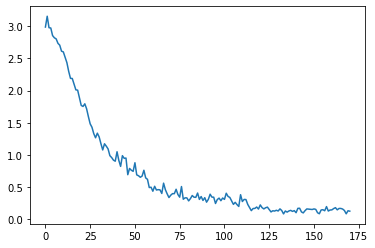

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

### With Glove embeddings: 

Now, we would like to integrate pre-trained word embeddings into our model ! Let's use again the functions that we used in the previous TP:

### **Comments :**

The code above is used to load the pre-trained GloVe word embeddings and adapt them to the vocabulary used in your dataset.

- First, it imports the gensim.downloader as api and loads the "glove-wiki-gigaword-300" model using the api.load() function. This model contains 300-dimensional GloVe word embeddings trained on the Wikipedia and Gigaword datasets.

- It retrieves the vectors of the GloVe model and stores them in loaded_glove_embeddings.

- The get_glove_adapted_embeddings function is defined, which takes a GloVe model (glove_model) and the input vocabulary (input_voc) as its arguments. This function is used to adapt the pre-trained GloVe embeddings to the vocabulary used in your dataset.

- Inside the function :

  - it creates a dictionary keys that maps the words in your input vocabulary to their corresponding GloVe embedding keys, if available.

  - It initializes an empty NumPy array embeddings with the shape (len(input_voc)+1, glove_model.vectors.shape[1]) to store the adapted embeddings. The extra +1 in the length of the input vocabulary accounts for the padding token.

  - It populates the embeddings array with the corresponding GloVe embeddings for each word in the input vocabulary. If a word is not found in the GloVe model, its embedding will remain as a zero vector.

  - Finally, it calls the get_glove_adapted_embeddings function with the loaded_glove_model and training_word2idx to create the adapted embeddings for your dataset and stores them in the GloveEmbeddings variable.

In [ ]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")
loaded_glove_embeddings = loaded_glove_model.vectors

In [ ]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key.index for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

In [ ]:
print(GloveEmbeddings.shape)
# We should check that the "padding" vector is at zero
print(GloveEmbeddings[0])

(5003, 300)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Here, implement a ```PretrainedAveragingModel``` very similar to the previous model, using the ```nn.Embedding``` method ```from_pretrained()``` to initialize the embeddings from a numpy array. Use the ```requires_grad_``` method to specify if the model must fine-tune the embeddings or not ! 
<div class='alert alert-block alert-info'>
            Code:</div>

### **Comments :** 

- In the __init__ method, you pass the pretrained_embeddings, nb_classes, and an optional fine_tune parameter. 
  - The fine_tune parameter is a boolean that indicates whether the model should fine-tune the embeddings during training or not. By default, it is set to False.

- The nn.Embedding.from_pretrained() method is used to create the embedding object with pre-trained embeddings. 
  - The freeze argument is set to the opposite of the fine_tune value to make sure the embeddings are fine-tuned only when fine_tune is True. 
  - The requires_grad_() method is used to set the requires_grad attribute according to the fine_tune value.

In [ ]:
class PretrainedAveragingModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, nb_classes, pretrained_embeddings, fine_tune=False):
        super().__init__()
        # Create an embedding object with pre-trained embeddings
        self.embeddings = nn.Embedding.from_pretrained(torch.tensor(pretrained_embeddings).clone().detach().float(), freeze=not fine_tune)
        
        # Set requires_grad to fine-tune or not the embeddings
        self.embeddings.requires_grad_(fine_tune)
        
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.linear = nn.Linear(embedding_dim, nb_classes)
        
    def forward(self, inputs):
        # Take the mean of the embeddings of the document
        x = torch.mean(self.embeddings(inputs), dim=1)
        
        # Make it go through the linear layer and remove the extra dimension with the method .squeeze()
        o = self.linear(x).squeeze()
        return o

### **Questions:** 
- What are the results **with and without fine-tuning of embeddings imported from GloVe** ?
- Make hypothesis based on your intuition and the class on how the size of the vocabulary (change the minimum frequency of words to be taken in the vocabular) will impact results, in the three cases (No pre-training, pre-training without fine-tuning, pretraining with fine-tuning).
- Verify experiments and analyze your results !

<div class='alert alert-block alert-warning'>
            Questions:</div>

<div class='alert alert-block alert-info'>
            Code:</div>

### **Answers :**

The potential outcomes of each scenario in the experiments :

- **No pre-training:**
In this case, the model will learn embeddings from scratch. The performance may be lower compared to the scenarios with pre-trained embeddings, especially if the dataset is small or the vocabulary size is large.

- **Pre-training without fine-tuning:**
Using pre-trained GloVe embeddings without fine-tuning can lead to better performance than without pre-training. The embeddings have been trained on a massive corpus, capturing useful semantic information. However, since the embeddings are not fine-tuned, the model may not adapt well to the specific characteristics of the dataset.

- **Pre-training with fine-tuning:**
Fine-tuning the pre-trained embeddings can lead to the best performance, as it allows the model to leverage the knowledge from the pre-trained embeddings while adapting to the nuances of the dataset during training.

To test our hypotheses, we can perform experiments with varying vocabulary sizes by changing the minimum frequency of words to be taken in the vocabulary.

For each vocabulary size, train the three types of models (no pre-training, pre-training without fine-tuning, and pre-training with fine-tuning) and compare their performances using metrics like accuracy, loss, etc.

Intuitively, as the vocabulary size increases:

- **No pre-training:**
The model's performance may degrade due to the increased complexity and potential overfitting, especially with limited training data.

- **Pre-training without fine-tuning:**
The performance should be more stable compared to the no pre-training scenario since the model leverages pre-trained embeddings. However, it might still be affected by the vocabulary size since the model can't adapt to the dataset's specificities.

- **Pre-training with fine-tuning:**
The model's performance should be the least affected by the increased vocabulary size. Fine-tuning allows the model to adapt to the dataset's specificities while leveraging the pre-trained embeddings.


In [ ]:
model_pre_trained = PretrainedAveragingModel(300, len(training_word2idx), len(newsgroups_train.target_names), torch.FloatTensor(GloveEmbeddings), True)
opt_pre_trained = optim.Adam(model_pre_trained.parameters(), lr=0.05, betas=(0.9, 0.999))

<ipython-input-169-f4ff000c4012>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embeddings = nn.Embedding.from_pretrained(torch.tensor(pretrained_embeddings).float(), freeze=not fine_tune)


In [ ]:
train_losses = experiment(model_pre_trained, opt_pre_trained, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 2.988069772720337; training acc = 6.0
Batch 20 : training loss = 1.1258890628814697; training acc = 70.0
Batch 40 : training loss = 0.6080073714256287; training acc = 82.0
Epoch 1 : Validation loss = 0.7876603468660487; Validation acc = 77.14285714285715
Epoch 2:
Batch 0 : training loss = 0.21286499500274658; training acc = 94.5
Batch 20 : training loss = 0.12253055721521378; training acc = 97.5
Batch 40 : training loss = 0.2058873027563095; training acc = 94.5
Epoch 2 : Validation loss = 0.8455454419977617; Validation acc = 78.18921475875119
Early stopping.
Epoch 2 : Test loss = 0.8455454419977617; Test acc = 78.18921475875119


In [ ]:
## Redefining experiment function

def train_epoch(model, opt, criterion, dataloader):
    model.train()
    losses = []
    for i, (x, y) in enumerate(dataloader):
        opt.zero_grad()
        # (1) Forward
        pred = model(x)
        # (2) Compute the loss 
        loss = criterion(pred, y)
        # (3) Compute gradients with the criterion
        loss.backward()
        # (4) Update weights with the optimizer
        opt.step()
        losses.append(loss.item())
        # Count the number of correct predictions in the batch 
        num_corrects = (torch.argmax(pred, dim=1) == y).sum().item()
        acc = 100.0 * num_corrects/len(y)
        
        #if (i%20 == 0):
            #print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc)) #.item()
    return losses

    
# A function which will help you execute experiments rapidly - with a early_stopping option when necessary. 
def experiment(model, opt, criterion, num_epochs = 5, early_stopping = True):
    train_losses = []
    if early_stopping: 
        best_valid_loss = 100000. 
    for e in range(num_epochs):
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, test_dataloader)
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    return train_losses

<ipython-input-169-f4ff000c4012>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embeddings = nn.Embedding.from_pretrained(torch.tensor(pretrained_embeddings).float(), freeze=not fine_tune)


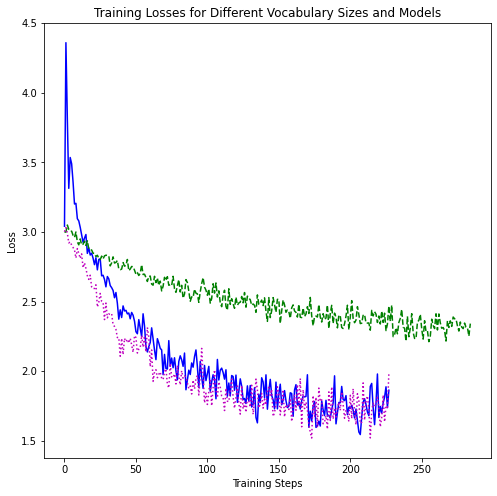

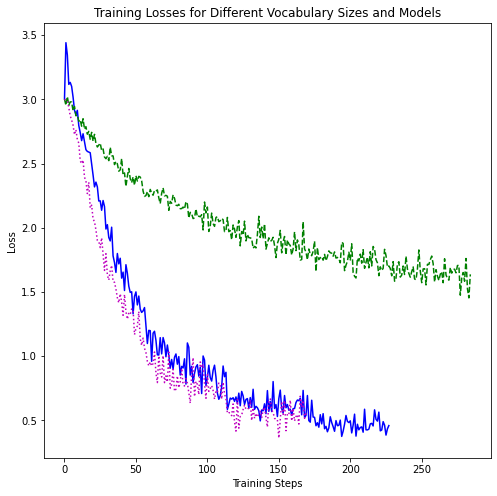

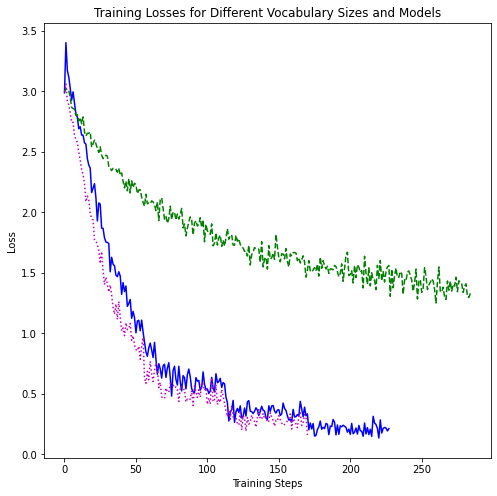

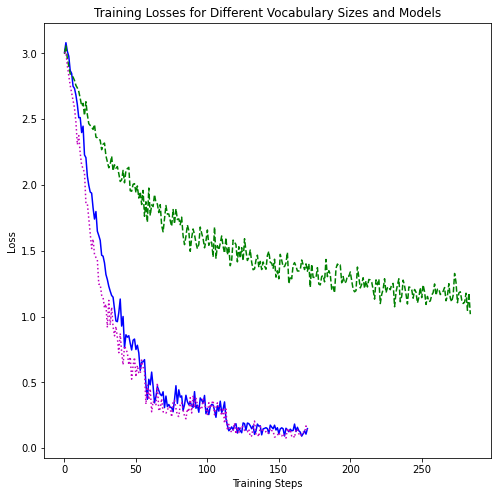

In [ ]:
import matplotlib.pyplot as plt

# Define a list of vocabulary size thresholds
vocab_thresholds = [200, 1000, 2000, 5000]

# Initialize lists to store train_losses for each scenario
no_pretrain_losses = []
pretrain_no_finetune_losses = []
pretrain_finetune_losses = []

# Iterate through vocabulary size thresholds
for threshold in vocab_thresholds:

    no_pretrain_losses = []
    pretrain_no_finetune_losses = []
    pretrain_finetune_losses = []

    # Update the vocabulary by modifying the threshold
    # Update training_word2idx and idx2word accordingly
    
    training_dataset = TextClassificationDataset(newsgroups_train['data'], newsgroups_train['target'], voc_threshold=threshold)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    
    # Update test dataset and create new data loaders
    test_dataset = TextClassificationDataset(newsgroups_test['data'], newsgroups_test['target'], (training_word2idx, training_idx2word))
    training_dataloader = DataLoader(training_dataset, batch_size=200, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=25)
    # Train the three types of models and obtain their train_losses
    # 1. No pre-training
    model_no_pretrain = AveragingModel(300, len(training_word2idx), len(newsgroups_train.target_names))
    opt_no_pretrain = optim.Adam(model_no_pretrain.parameters(), lr=0.025, betas=(0.9, 0.999))
    train_losses_no_pretrain = experiment(model_no_pretrain, opt_no_pretrain, criterion)

    # 2. Pre-training without fine-tuning
    model_pretrain_no_finetune = PretrainedAveragingModel(300, len(training_word2idx), len(newsgroups_train.target_names), torch.FloatTensor(GloveEmbeddings), fine_tune=False)
    opt_pretrain_no_finetune = optim.Adam(model_pretrain_no_finetune.parameters(), lr=0.025, betas=(0.9, 0.999))
    train_losses_pretrain_no_finetune = experiment(model_pretrain_no_finetune, opt_pretrain_no_finetune, criterion)

    # 3. Pre-training with fine-tuning
    model_pretrain_finetune = PretrainedAveragingModel(300, len(training_word2idx), len(newsgroups_train.target_names), torch.FloatTensor(GloveEmbeddings), fine_tune=True)
    opt_pretrain_finetune = optim.Adam(model_pretrain_finetune.parameters(), lr=0.025, betas=(0.9, 0.999))
    train_losses_pretrain_finetune = experiment(model_pretrain_finetune, opt_pretrain_finetune, criterion)

    # Plot the train_losses for each scenario
    fig= plt.figure(figsize=(8,8))
    #for i, threshold in enumerate(vocab_thresholds):
    plt.plot(train_losses_no_pretrain, color='b', linestyle='-') #label=f'No Pretrain - Vocab Threshold {threshold}',
    plt.plot(train_losses_pretrain_no_finetune, color='g',  linestyle='--') #label=f'Pretrain No Finetune - Vocab Threshold {threshold}',
    plt.plot(train_losses_pretrain_finetune, color='m',  linestyle=':') #label=f'Pretrain Finetune - Vocab Threshold {threshold}',

    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    #plt.legend(train_losses_no_pretrain,train_losses_pretrain_no_finetune,train_losses_pretrain_finetune)
    plt.title('Training Losses for Different Vocabulary Sizes and Models')
    plt.show()


### LSTM Cells in pytorch

In [ ]:
# Create a toy example of LSTM: 
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# LSTMs expect inputs having 3 dimensions:
# - The first dimension is the temporal dimension, along which we (in our case) have the different words
# - The second dimension is the batch dimension, along which we stack the independant batches
# - The third dimension is the feature dimension, along which are the features of the vector representing the words

# In our toy case, we have inputs and outputs containing 3 features (third dimension !)
# We created a sequence of 5 different inputs (first dimension !)
# We don't use batch (the second dimension will have one lement)

# We need an initial hidden state, of the right sizes for dimension 2/3, but with only one temporal element:
# Here, it is:
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
# Why do we create a tuple of two tensors ? Because we use LSTMs: remember that they use two sets of weights,
# and two hidden states (Hidden state, and Cell state).
# If you don't remember, read: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
# If we used a classic RNN, we would simply have:
# hidden = torch.randn(1, 1, 3)

# The naive way of applying a lstm to inputs is to apply it one step at a time, and loop through the sequence
for i in inputs:
    # After each step, hidden contains the hidden states (remember, it's a tuple of two states).
    out, hidden = lstm(i.view(1, 1, -1), hidden)
    
# Alternatively, we can do the entire sequence all at once.
# The first value returned by LSTM is all of the Hidden states throughout the sequence.
# The second is just the most recent Hidden state and Cell state (you can compare the values)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence, for each temporal step
# "hidden" will allow you to continue the sequence and backpropagate later, with another sequence
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # Re-initialize
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[-0.0117,  0.1513,  0.1567]],

        [[-0.0254,  0.3077,  0.0396]],

        [[-0.2639,  0.1023,  0.0169]],

        [[-0.0122,  0.0564,  0.0268]],

        [[ 0.0566, -0.1773,  0.1526]]], grad_fn=<StackBackward0>)
(tensor([[[ 0.0566, -0.1773,  0.1526]]], grad_fn=<StackBackward0>), tensor([[[ 0.2504, -0.4489,  0.4070]]], grad_fn=<StackBackward0>))


### Creating our own LSTM Model

We'll implement now a LSTM model, taking the same inputs and also outputing a score for the sentence.
<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Models are usually implemented as custom nn.Module subclass
# We need to redefine the __init__ method, which creates the object
# We also need to redefine the forward method, which transform the input into outputs

class LSTMModel(nn.Module): 
    def __init__(self, embedding_dim, vocabulary_size, hidden_dim,nb_classes, embeddings=None, fine_tuning=False):
        # To complete 
        # You will need to create the LSTM layer before the linear layer : use nn.LSTM and be careful with the dimensions !
        super().__init__()

        # Create an embedding object
        if embeddings is not None:
            self.embeddings = nn.Embedding.from_pretrained(torch.tensor(embeddings).clone().detach().float(), freeze=not fine_tuning)
        else:
            self.embeddings = nn.Embedding(vocabulary_size, embedding_dim)
        
        # Create an LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        
        # Create a linear layer that will transform the hidden state into a classification score
        self.linear = nn.Linear(hidden_dim, nb_classes)

    def forward(self, inputs):
        # To complete 
        # Process the input and apply the LSTM
        # The output will have three dimensions (batch, temporal, nb_classes) - there is one that we won't entirely keep, since this is a many-to-one network
        # Process the input and apply the embeddings
        x = self.embeddings(inputs)
        
        # Apply the LSTM
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Take the last hidden state from the LSTM output
        last_hidden = self.linear(lstm_out[:, -1, :])
        
        # Make it go through the linear layer and remove the extra dimension with the method .squeeze()
        o = last_hidden.squeeze()
        return o


### Questions: 
- What do you see with a simple application of LSTM models ? (Again, try with the three possible settings !) What are possible reasons for this ? (these could be linked to the data, the way it is pre-processed, the architecture, and the training procedure). 

<div class='alert alert-block alert-warning'>
            Questions:</div>

In [ ]:
recurrent_model = LSTMModel(300, len(training_word2idx), 100, len(newsgroups_train.target_names), torch.FloatTensor(GloveEmbeddings), True)
opt_recurrent = optim.Adam(recurrent_model.parameters(), lr=0.025, betas=(0.9, 0.999))

<ipython-input-210-bec089698144>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embeddings = nn.Embedding.from_pretrained(torch.tensor(embeddings).clone().detach().float(), freeze=not fine_tuning)


In [ ]:
train_losses = experiment(recurrent_model, opt_recurrent, criterion)

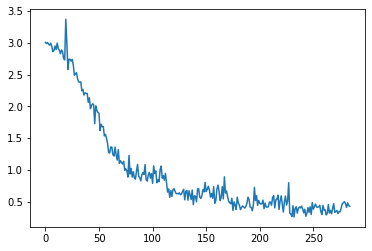

In [ ]:
plt.plot(train_losses)

# Fine-tuning a Bert model

Fine-tune the lightest BERT model available on the data and compare it with previous results ! The code given here comes from the following tutorial, slightly adapted to our data:
https://huggingface.co/transformers/custom_datasets.html#seq-imdb

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
!pip install transformers
import transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.3 MB/s eta 0:00:00


In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(newsgroups_train['data'], truncation=True, padding=True)
test_encodings = tokenizer(newsgroups_test['data'], truncation=True, padding=True)

In [ ]:
class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ClassificationDataset(train_encodings, newsgroups_train['target'])
test_dataset = ClassificationDataset(test_encodings, newsgroups_test['target'])

In [ ]:
from transformers import TrainingArguments
from sklearn.metrics import accuracy_score  

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=1,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    logging_steps=250,
)

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = len(newsgroups_train.target_names))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

In [ ]:
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,           
    compute_metrics=compute_metrics             
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,2.470300
500,1.005800


TrainOutput(global_step=708, training_loss=1.4042514219122417, metrics={'train_runtime': 551.228, 'train_samples_per_second': 20.525, 'train_steps_per_second': 1.284, 'total_flos': 1499217249361920.0, 'train_loss': 1.4042514219122417, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6218549013137817,
 'eval_accuracy': 0.8146574614976102,
 'eval_runtime': 133.095,
 'eval_samples_per_second': 56.591,
 'eval_steps_per_second': 0.887,
 'epoch': 1.0}